#Python libraries for the BITM ( Browser-In-The-Middle ) phishing detection a short overview:

**Data Handling Libraries:** numpy, pandas - Essential for numerical operations and data manipulation.
Visualization: seaborn, matplotlib.pyplot - Used for creating visualizations to explore and present data.

**Model Building and Evaluation:**
Data Splitting: train_test_split - Divides data into training and testing sets for model validation.

**Metrics**: accuracy_score, precision_score, recall_score, f1_score - Evaluate model performance.

**Preprocessing:** ColumnTransformer, SimpleImputer, OneHotEncoder, MinMaxScaler - Handle missing values, encode categorical data, and scale features.

**Modeling**: Various classifiers like SVC, MLPClassifier, RandomForestClassifier, DecisionTreeClassifier, GaussianNB, XGBClassifier, KNeighborsClassifier - Different algorithms for classification tasks.

**Feature Selection**: SelectKBest - Selects the most relevant features based on statistical tests.

**Cross-Validation**: cross_val_score - Assesses model performance across multiple folds of the data for robustness.

In [1]:
import numpy as np
import pandas as pd

In [30]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve, roc_auc_score



In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#Data Collection and Organization

The Browser-in-the-Middle (BitM) architecture was replicated on a local machine using VirtualBox (version 6.7.10) with two Ubuntu 22.4 LTS instances. The setup involved three distinct machines: a victim machine, an attacker’s machine, and an intended server. Wireshark (version 4.0.9) was installed on the victim machine to intercept and capture network traffic, producing pcap files for analysis. Two types of traffic were generated: safe and malicious.

Malicious traffic was captured when the victim clicked a phishing link, which created a remote connection to the intended server through the attacker’s machine. In contrast, safe traffic was captured when the victim connected directly to the intended server without any malicious intervention.


The pcap files revealed different attributes for safe and malicious traffic. Specifically, data packets were captured in total—60% were identified as malicious and 40% as safe. The next step in the analysis involves importing these pcap files into Google Collaboratory, where the 'tshark' tool used to process and analyze the network packet data to differentiate between the two types of traffic by labeling them into a csv file.

In [4]:
df = pd.read_csv('/content/browser_in_the_middle_phishing_dataset.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11912 entries, 0 to 11911
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   frame.time_relative  11912 non-null  float64
 1   frame.len            11912 non-null  int64  
 2   sll.pkttype          11912 non-null  int64  
 3   sll.hatype           11912 non-null  int64  
 4   sll.unused           11912 non-null  object 
 5   sll.etype            11912 non-null  object 
 6   ip.version           11912 non-null  int64  
 7   ip.hdr_len           11912 non-null  int64  
 8   ip.dsfield           11912 non-null  object 
 9   ip.dsfield.dscp      11912 non-null  int64  
 10  ip.len               11912 non-null  int64  
 11  ip.flags             11912 non-null  object 
 12  ip.flags.df          11912 non-null  int64  
 13  ip.ttl               11912 non-null  int64  
 14  ip.proto             11912 non-null  int64  
 15  Label                11912 non-null 

In [6]:
import pandas as pd

# Counting  unique values in each column
unique_value_counts = df.nunique()

# Displaying the result
print(unique_value_counts)


frame.time_relative    11547
frame.len               1042
sll.pkttype                4
sll.hatype                 2
sll.unused              5087
sll.etype                  1
ip.version                 1
ip.hdr_len                 2
ip.dsfield                 4
ip.dsfield.dscp            4
ip.len                  1043
ip.flags                   2
ip.flags.df                2
ip.ttl                    10
ip.proto                   3
Label                      2
dtype: int64


# Preprocessing

In [7]:
df.drop(columns=['sll.unused','ip.flags.df','ip.dsfield.dscp','ip.version','ip.len','sll.etype'],inplace=True)

In [8]:

# Count unique values in each column
unique_value_counts = df.nunique()
# Display the result
print(unique_value_counts)

frame.time_relative    11547
frame.len               1042
sll.pkttype                4
sll.hatype                 2
ip.hdr_len                 2
ip.dsfield                 4
ip.flags                   2
ip.ttl                    10
ip.proto                   3
Label                      2
dtype: int64


#Columns for ONE-HOT Encoding

 It first identifies the top 3 unique values for each column of interest ('ip.dsfield' and 'ip.flags'). Values not in the top 3 are replaced with 'Other'. Subsequently, it performs one-hot encoding on these columns, converting categorical variables into binary columns. The resulting DataFrame, df_encoded, includes these new binary columns reflecting the top values and the 'Other' category. The final dataset with these transformations is then displayed.

In [9]:
#  the number of top unique values to keep
top_n_values = 3
#  top n unique values for each of the columns to one-hot encode
top_values = {}
columns_to_one_hot = [ 'ip.dsfield','ip.flags']
#columns_to_one_hot = ['sll.pkttype', 'sll.hatype', 'ip.hdr_len', 'ip.dsfield', 'ip.dsfield.dscp', 'ip.flags', 'ip.flags.df', 'ip.proto','ip.ttl']

for col in columns_to_one_hot:
    top_values[col] = df[col].value_counts().head(top_n_values).index.tolist()

# Replaceing values not in the top n with 'Other' for each column
for col in columns_to_one_hot:
    df[col] = df[col].apply(lambda x: x if x in top_values[col] else 'Other')

# one-hot encoding for all the specified columns
df_encoded = pd.get_dummies(df, columns=columns_to_one_hot)

# Displaying the new dataset
print(df_encoded)



       frame.time_relative  frame.len  sll.pkttype  sll.hatype  ip.hdr_len  \
0                 0.000000         62            2           1          20   
1                 0.017837         62            2           1          24   
2                 2.059293         92            0         772          20   
3                 2.059310         92            0         772          20   
4                 2.059544         81            4           1          20   
...                    ...        ...          ...         ...         ...   
11907            84.316854         68            0           1          20   
11908            84.685033        251            0           1          20   
11909            84.685659         84            4           1          20   
11910            84.686572         84            4           1          20   
11911            84.687398         68            0           1          20   

       ip.ttl  ip.proto  Label  ip.dsfield_0x00  ip.dsfield_0x6

In [10]:
df_encoded.drop(columns=['ip.flags_0x40'],inplace=True)

df_encoded.info()  # Displaying the new dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11912 entries, 0 to 11911
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   frame.time_relative  11912 non-null  float64
 1   frame.len            11912 non-null  int64  
 2   sll.pkttype          11912 non-null  int64  
 3   sll.hatype           11912 non-null  int64  
 4   ip.hdr_len           11912 non-null  int64  
 5   ip.ttl               11912 non-null  int64  
 6   ip.proto             11912 non-null  int64  
 7   Label                11912 non-null  int64  
 8   ip.dsfield_0x00      11912 non-null  bool   
 9   ip.dsfield_0x60      11912 non-null  bool   
 10  ip.dsfield_0xc0      11912 non-null  bool   
 11  ip.dsfield_Other     11912 non-null  bool   
 12  ip.flags_0x00        11912 non-null  bool   
dtypes: bool(5), float64(1), int64(7)
memory usage: 802.8 KB


In [11]:
df_encoded.head(10)

,frame.time_relative,frame.len,sll.pkttype,sll.hatype,ip.hdr_len,ip.ttl,ip.proto,Label,ip.dsfield_0x00,ip.dsfield_0x60,ip.dsfield_0xc0,ip.dsfield_Other,ip.flags_0x00
0,0.000000,62,2,1,20,1,2,0,True,False,False,False,False
1,0.017837,62,2,1,24,1,2,0,False,False,True,False,False
2,2.059293,92,0,772,20,64,17,0,True,False,False,False,False
3,2.059310,92,0,772,20,64,17,0,True,False,False,False,False
4,2.059544,81,4,1,20,64,17,0,True,False,False,False,False
5,2.059696,81,4,1,20,64,17,0,True,False,False,False,False
6,2.075831,97,0,772,20,64,17,0,True,False,False,False,False
7,2.075852,97,0,772,20,64,17,0,True,False,False,False,False
8,2.076003,86,4,1,20,64,17,0,True,False,False,False,False
9,2.076189,86,4,1,20,64,17,0,True,False,False,False,False


In [12]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11912 entries, 0 to 11911
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   frame.time_relative  11912 non-null  float64
 1   frame.len            11912 non-null  int64  
 2   sll.pkttype          11912 non-null  int64  
 3   sll.hatype           11912 non-null  int64  
 4   ip.hdr_len           11912 non-null  int64  
 5   ip.ttl               11912 non-null  int64  
 6   ip.proto             11912 non-null  int64  
 7   Label                11912 non-null  int64  
 8   ip.dsfield_0x00      11912 non-null  bool   
 9   ip.dsfield_0x60      11912 non-null  bool   
 10  ip.dsfield_0xc0      11912 non-null  bool   
 11  ip.dsfield_Other     11912 non-null  bool   
 12  ip.flags_0x00        11912 non-null  bool   
dtypes: bool(5), float64(1), int64(7)
memory usage: 802.8 KB


In [ ]:
# function to perform the operation on the 12th column
def modify_column(column):
    modified_column = [column[0]]  #  modified column with the first value
    for i in range(1, len(column)):
        difference = column[i] - column[i - 1]  # Calculating the difference
        modified_column.append(difference)  # Appending the difference to the modified column
    return modified_column

# Applying the operation to the 12th column
column_12 =df_encoded.iloc[:, 0]  # Assuming column indexing is zero-based
modified_column_12 = modify_column(column_12)
df_encoded.iloc[:, 0] = modified_column_12

# To save to a new CSV file with a different name, use a different file path
df_encoded.to_csv('time bitm dataset.csv', index=False)
df_encoded.head()

,frame.time_relative,frame.len,sll.pkttype,sll.hatype,ip.hdr_len,ip.ttl,ip.proto,Label,ip.dsfield_0x00,ip.dsfield_0x60,ip.dsfield_0xc0,ip.dsfield_Other,ip.flags_0x00
0,0.000000,62,2,1,20.0,1.0,2.0,0,True,False,False,False,False
1,0.017837,62,2,1,24.0,1.0,2.0,0,False,False,True,False,False
2,2.041456,92,0,772,20.0,64.0,17.0,0,True,False,False,False,False
3,0.000017,92,0,772,20.0,64.0,17.0,0,True,False,False,False,False
4,0.000234,81,4,1,20.0,64.0,17.0,0,True,False,False,False,False


In [13]:
df['Label'].value_counts()

,count
Label,
1,7339
0,4573


In [25]:
# train/test/split
X_train, X_test, y_train, y_test = train_test_split(df_encoded.drop(columns=['Label']),
                                                 df['Label'],
                                                 test_size=0.27,
                                                 random_state=42)

#Destribution of Data for Training set and Testing set
In a BitM phishing detection scenario, the datasets could represent legitimate and phishing traffic or behaviors. The two classes in the pie charts—labeled as 0 and 1—likely represent two categories:

-Class 0 (Blue): Legitimate traffic or normal behavior.

-Class 1 (Pink): BitM Phishing traffic or malicious behavior.


##Training Set:
61.8% of the training set data belongs to Class 1, which represents BitM phishing traffic.
38.2% belongs to Class 0, representing legitimate traffic.

The training set distribution shows that BitM phishing examples dominate, helping the model learn the patterns associated with phishing attacks in Browser-In-The-Middle scenarios.

##Testing Set:
61.0% of the testing data is phishing-related (Class 1).

39.0% is legitimate (Class 0).

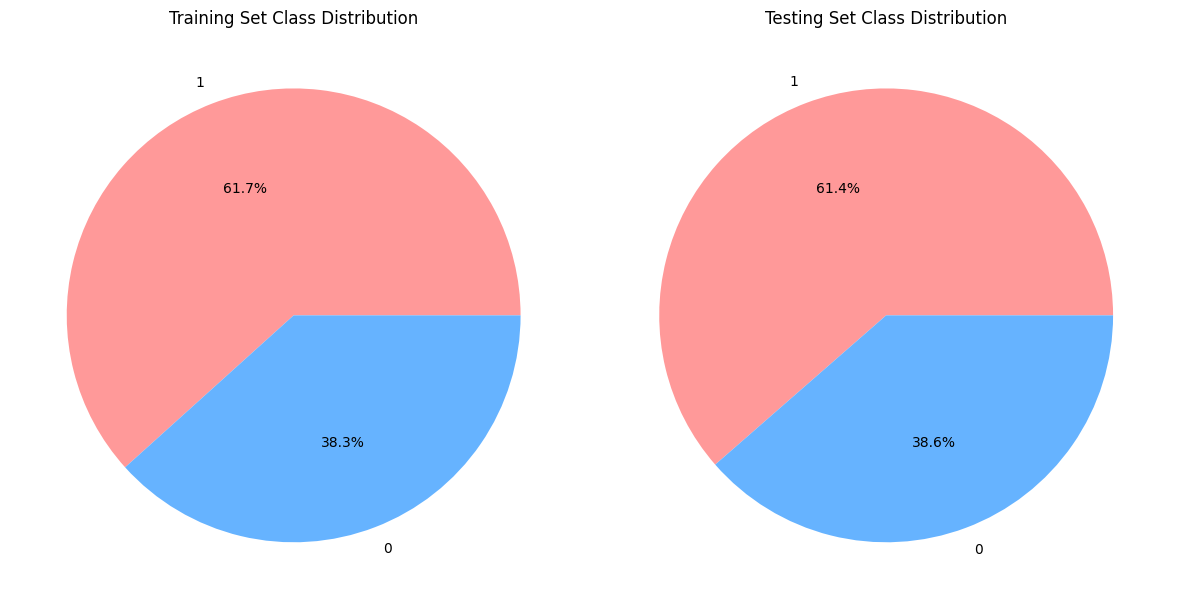

In [35]:
import matplotlib.pyplot as plt


# Calculating value counts for training and testing labels


train_labels = y_train.value_counts().reset_index()
train_labels.columns = ['Label', 'Count']

test_labels = y_test.value_counts().reset_index()
test_labels.columns = ['Label', 'Count']

# Plotting
plt.figure(figsize=(12, 6))

# Pie chart for training set
plt.subplot(1, 2, 1)
plt.pie(train_labels['Count'], labels=train_labels['Label'], autopct='%1.1f%%', colors=['#ff9999','#66b3ff'])
plt.title('Training Set Class Distribution')

# Pie chart for testing set
plt.subplot(1, 2, 2)
plt.pie(test_labels['Count'], labels=test_labels['Label'], autopct='%1.1f%%', colors=['#ff9999','#66b3ff'])
plt.title('Testing Set Class Distribution')
plt.tight_layout()
plt.show()

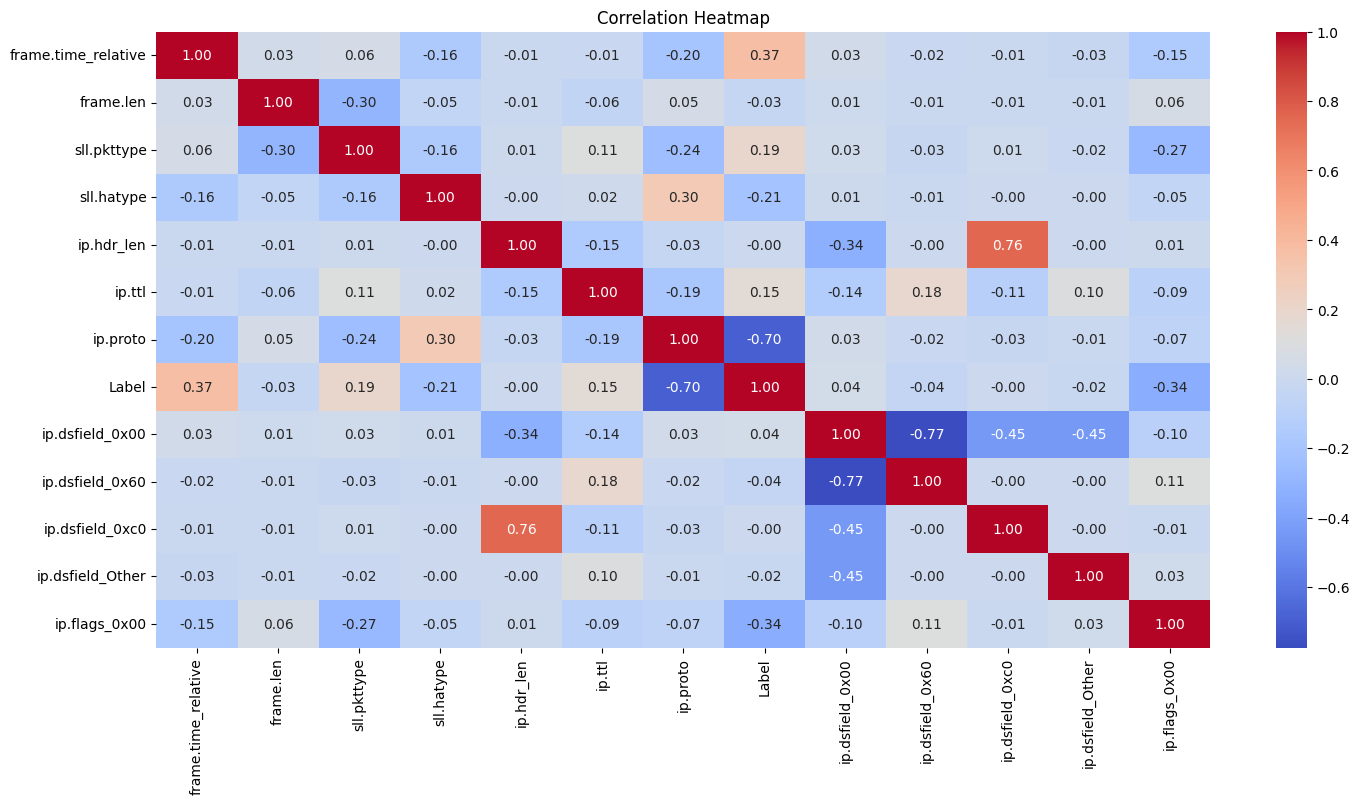

In [27]:

correlation_matrix = df_encoded.corr()

#heatmap to visualize the correlations
plt.figure(figsize=(17, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()


In [28]:
X_train.head()

,frame.time_relative,frame.len,sll.pkttype,sll.hatype,ip.hdr_len,ip.ttl,ip.proto,ip.dsfield_0x00,ip.dsfield_0x60,ip.dsfield_0xc0,ip.dsfield_Other,ip.flags_0x00
6994,42.779774,80,4,1,20,64,6,True,False,False,False,False
1702,6.078135,2868,0,1,20,56,6,True,False,False,False,True
10934,75.397820,199,0,1,20,64,6,True,False,False,False,False
61,2.320465,68,4,1,20,64,6,True,False,False,False,False
11719,80.510801,84,4,1,20,64,6,True,False,False,False,False


#Receiver Operating Characteristic (ROC) curve

The image displays a Receiver Operating Characteristic (ROC) curve for multiple classifiers used to detect phishing in a Browser-In-The-Middle (BitM) scenario. It shows the true positive rate (sensitivity) versus the false positive rate, with the Area Under the Curve (AUC) values listed for each model:



*   Random Forest: AUC = 0.995 (best performance)
*   Decision Tree: AUC = 0.990
*   MLP (Multi-Layer Perceptron): AUC = 0.965
*   Naive Bayes: AUC = 0.876
*   SVM (Support Vector Machine): AUC = 0.808


Higher AUC indicates better phishing detection performance.

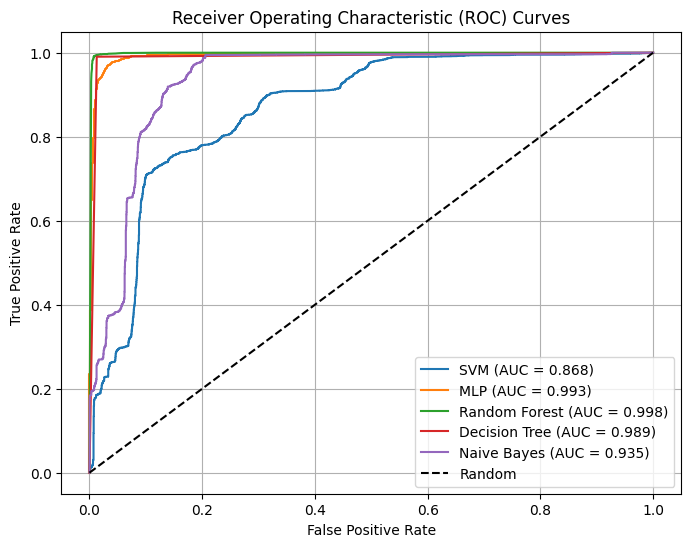

In [32]:


# classifiers
classifiers = [
    ("SVM", SVC(probability=True)),
    ("MLP", MLPClassifier()),
    ("Random Forest", RandomForestClassifier()),
    ("Decision Tree", DecisionTreeClassifier()),
    ("Naive Bayes", GaussianNB())
]

#empty list to store ROC data for each classifier
roc_data = []

# cross-validation and plot ROC curves
plt.figure(figsize=(8, 6))

for name, classifier in classifiers:
    y_scores = cross_val_predict(classifier, X_train, y_train, cv=5, method="predict_proba")
    fpr, tpr, _ = roc_curve(y_train, y_scores[:, 1])
    auc = roc_auc_score(y_train, y_scores[:, 1])

    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})')

    roc_data.append({
        "name": name,
        "fpr": fpr,
        "tpr": tpr,
        "auc": auc
    })

plt.plot([0, 1], [0, 1], 'k--', label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curves")
plt.legend(loc="lower right")
plt.grid()
plt.show()


#Comparing The Performance of Various Classifiers


Here the below findings compares the performance of various classifiers (SVM, MLP, Random Forest, Decision Tree, and Naive Bayes) using 10 and 6 K-best features for phishing detection.

Random Forest consistently shows the highest performance across metrics, with an accuracy of **0.99 (10 features) **and 0.94 (6 features), and the best F1 scores (0.99 and 0.96, respectively).

MLP also performs well with high precision and recall, especially with 10 features. SVM performs the lowest, while Naive Bayes achieves high recall but lower precision. Feature selection impacts overall performance, especially for SVM and MLP classifiers.

In [31]:

#k_best values for feature selection
k_best_values = [10, 6]

# Initialize classifiers
classifiers = {
    "SVM": SVC(),
    "MLP": MLPClassifier(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Naive Bayes": GaussianNB(),
 #   "XGBoost": XGBClassifier(),
 #   "KNN": KNeighborsClassifier(n_neighbors=5),
}

# multi-index DataFrame to store evaluation metrics
index = pd.MultiIndex.from_product([k_best_values, classifiers.keys()], names=['K Best Features', 'Classifier'])
results_df = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'CV Score'], index=index)

for k_best in k_best_values:
    # X_train and X_test with feature selection
    k_best_selector = SelectKBest(score_func=chi2, k=k_best)

    # X_train is non-negative for chi2
    X_train_non_negative = X_train.abs() # absolute value of X_train
    X_train_k_best = k_best_selector.fit_transform(X_train_non_negative, y_train)

    X_test_k_best = k_best_selector.transform(X_test)

    for clf_name, clf in classifiers.items():
        clf.fit(X_train_k_best, y_train)
        y_pred = clf.predict(X_test_k_best)

        # evaluation metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        # cross-validation score (e.g., 5-fold cross-validation)
        cross_val = cross_val_score(clf, X_train_k_best, y_train, cv=5).mean()

        results_df.loc[(k_best, clf_name)] = [accuracy, precision, recall, f1, cross_val]

# the results
results_df

Accuracy Precision    Recall  F1 Score  \
K Best Features Classifier                                              
10              SVM            0.799813  0.764496   0.97419  0.856698   
                MLP              0.9742  0.974912    0.9833  0.979088   
                Random Forest  0.991607  0.992919  0.993421   0.99317   
                Decision Tree  0.992229  0.991931  0.995445  0.993685   
                Naive Bayes    0.918247   0.88529  0.995951  0.937366   
6               SVM            0.799503  0.764402  0.973684  0.856443   
                MLP            0.968293  0.976602   0.97166  0.974125   
                Random Forest  0.989431  0.992893  0.989879  0.991384   
                Decision Tree  0.988499  0.990389  0.990891   0.99064   
                Naive Bayes    0.916382  0.882907  0.995951  0.936029   

                               CV Score  
K Best Features Classifier               
10              SVM             0.79448  
                MLP            0.973663  
                Random Forest  0.991259  
                Decision Tree  0.989649  
                Naive Bayes    0.914319  
6               SVM            0.794595  
                MLP            0.959057  
                Random Forest  0.989879  
                Decision Tree  0.987694  
                Naive Bayes    0.912133

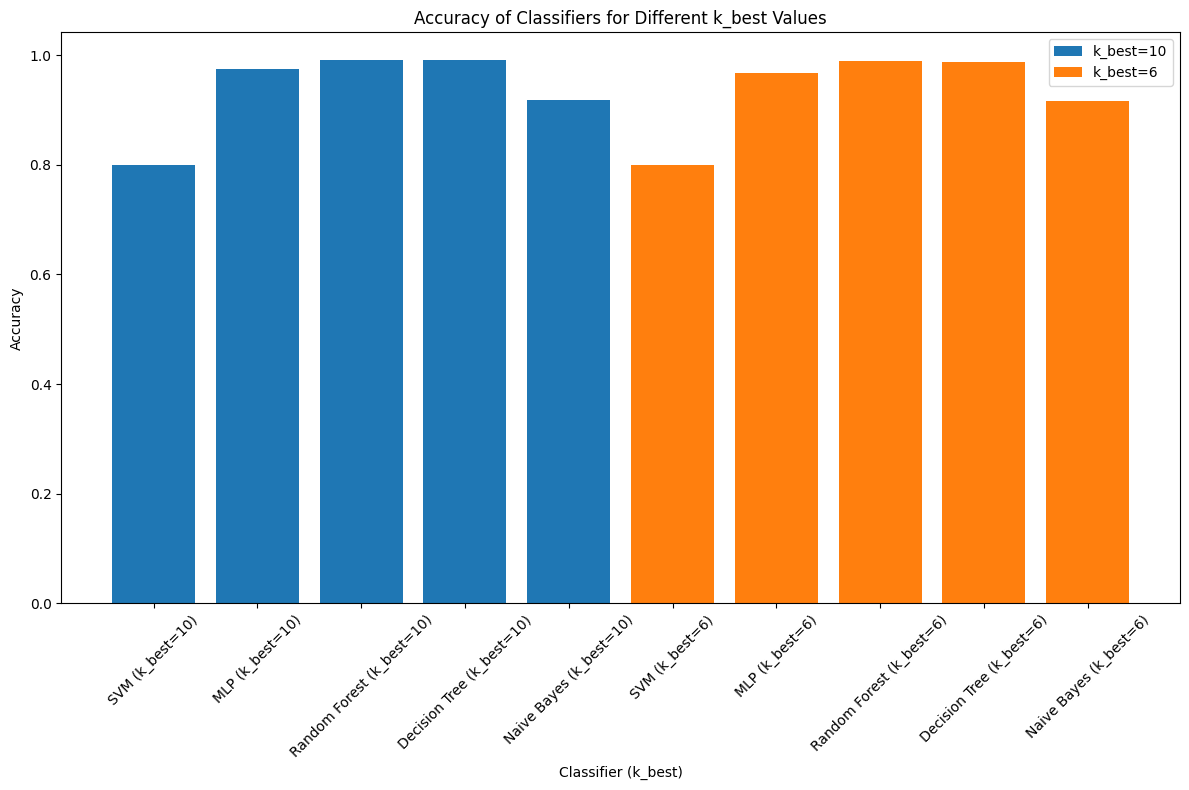

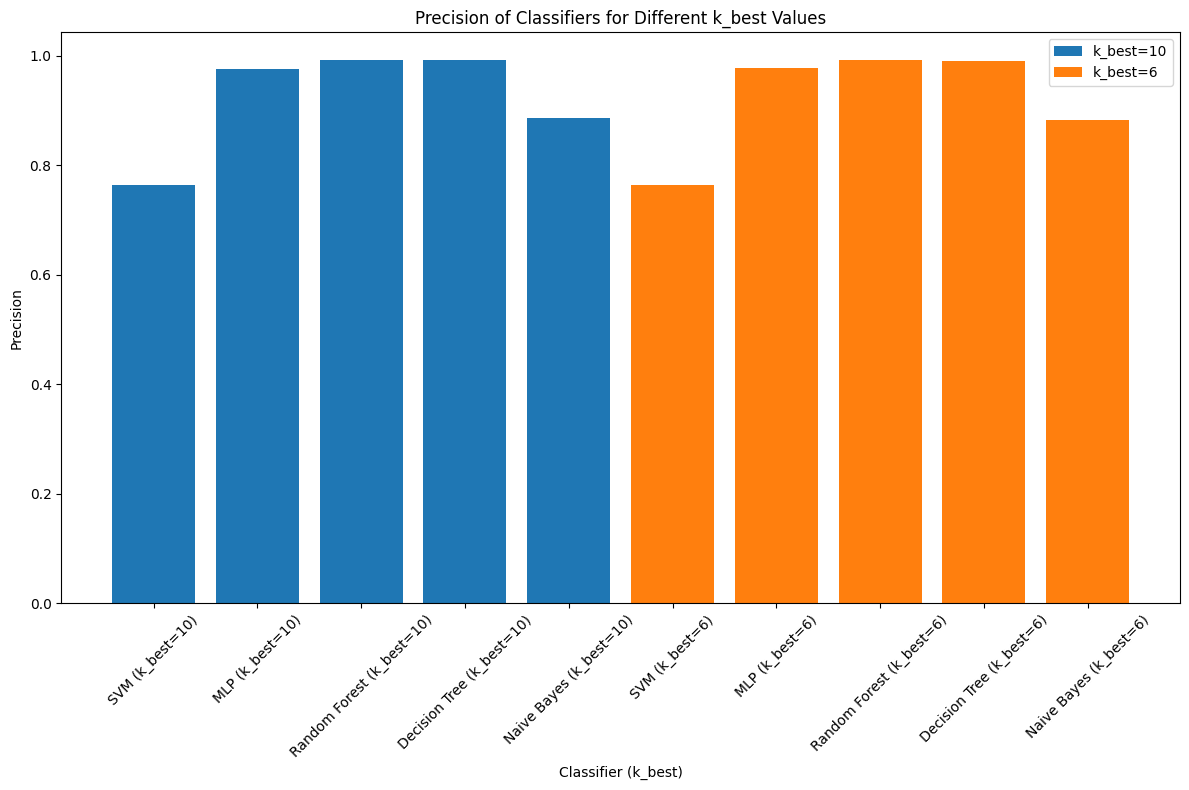

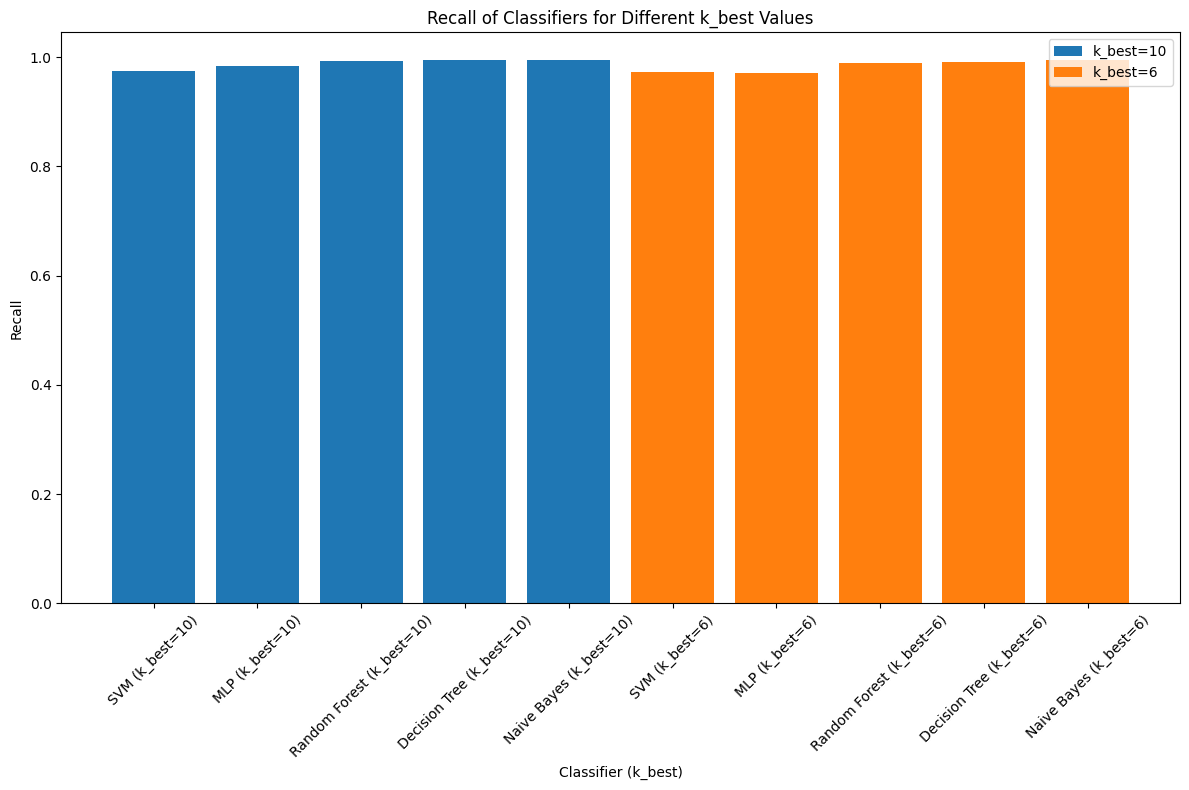

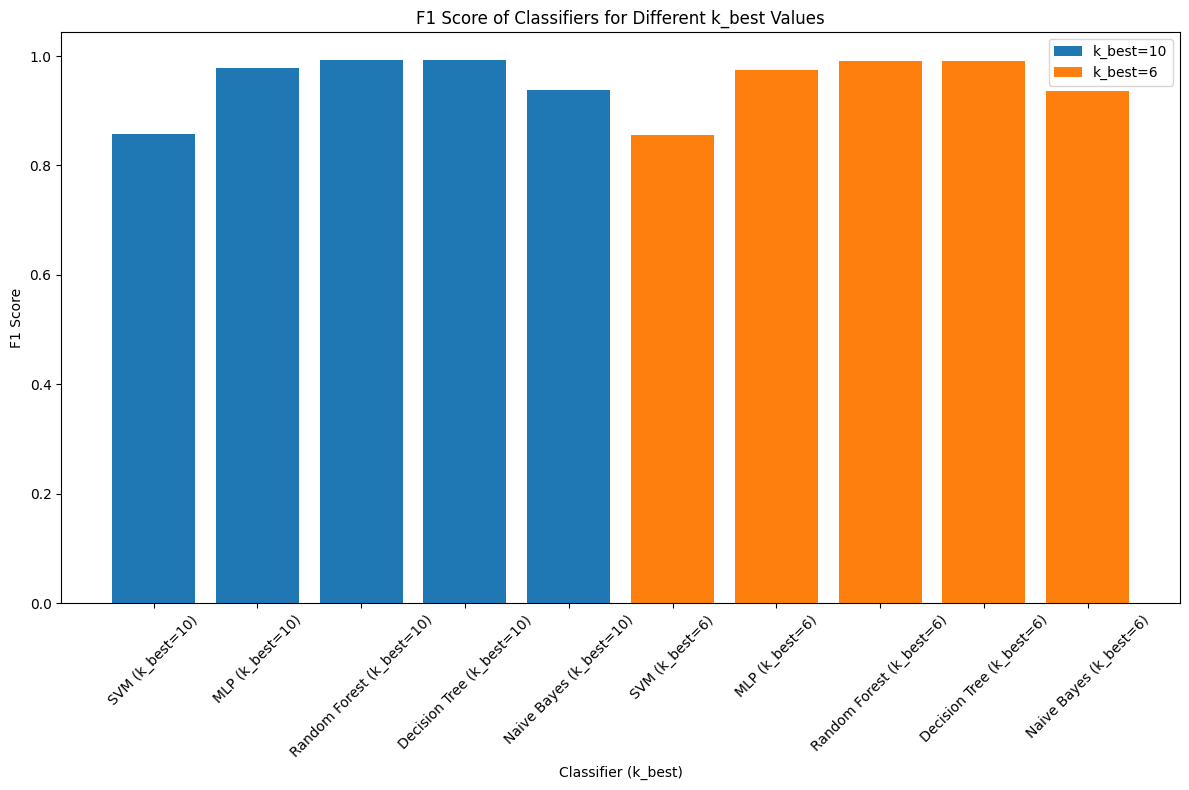

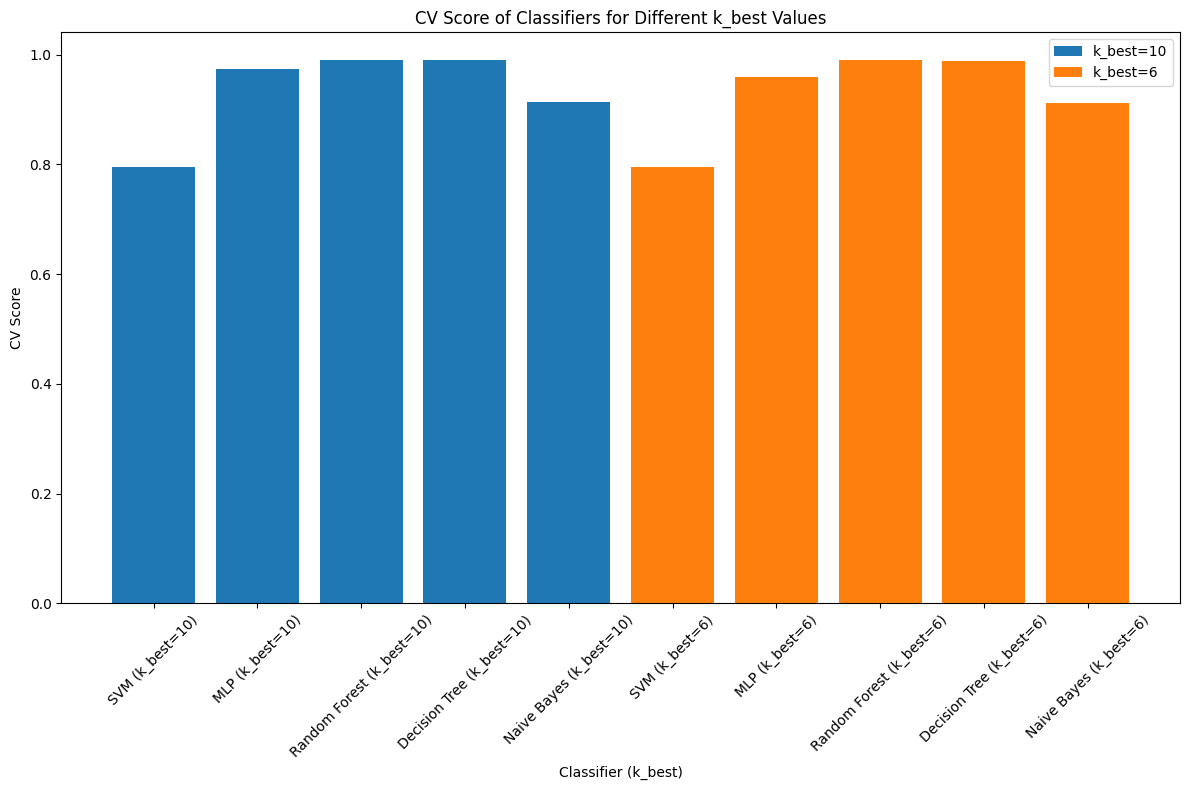

In [33]:
# Plotting bar charts
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'CV Score']

for metric in metrics:
    plt.figure(figsize=(12, 8))
    for k_best in k_best_values:
        data = results_df.loc[k_best].reset_index()
        plt.bar(data['Classifier'] + f' (k_best={k_best})', data[metric], label=f'k_best={k_best}')


    plt.xlabel('Classifier (k_best)')
    plt.ylabel(metric)
    plt.title(f'{metric} of Classifiers for Different k_best Values')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
